# Variant exploration
We've used the `nf-core/sarek` pipeline to call variants in our samples; now let's explore the data we have!

In [1]:
from os import listdir
from os.path import isfile, isdir
from pysam import VariantFile
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import seaborn as sns

## Read in the data
`0M` samples were grown without EMS in 10/10

`01M` samples were treated with EMS in 10/10

In [2]:
var_top_path = '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka'

In [3]:
snv_filepaths = {}
indel_filepaths = {}
for f in listdir(var_top_path):
    if isdir(f'{var_top_path}/{f}'):
        if f[:3] == '537':
            continue
        snv_path = f'{var_top_path}/{f}/{f}.strelka.somatic_snvs.vcf.gz'
        snv_filepaths[f] = snv_path
        indel_path = f'{var_top_path}/{f}/{f}.strelka.somatic_indels.vcf.gz'
        indel_filepaths[f] = indel_path

## Filtering by support
As mentioned in [this video](https://youtu.be/zO9WCOaq3aQ?si=GZD3t4__wenFgTxh&t=665), variants that only appear in a few reads are more likely to be sequencing errors than true variants. Therefore, we want to filter our variants. While Strelka2 doesn't provide a score in the `QUAL` column of the `vcf` file, it does provide a `PASS` value based on the Empirical Variant Scoring model (see [Supplementary Note 1](https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-018-0051-x/MediaObjects/41592_2018_51_MOESM1_ESM.pdf)) if the variant is good quality, or `LowEVS` or `LowDepth` if it's not a good variant.

In [4]:
all_alts = {}
all_conversions = {}
all_passed = {}
for sample, path in snv_filepaths.items():
    vcf = VariantFile(path)
    snvs = vcf.fetch()
    passed = []
    alts = defaultdict(int)
    conversions = defaultdict(int)
    total = 0
    for variant in snvs:
        if variant.filter.keys()[0] == 'PASS':
            # print(variant.chrom, variant.pos, variant.ref, ">", variant.alts[0], variant.qual, variant.filter.values()[0].name)
            passed.append(variant)
            alts[variant.alts[0]] += 1
            conversions[f'{variant.ref} > {variant.alts[0]}'] += 1
        total += 1
    print(f'For sample {sample}, {len(passed)} of {total} variants passed, which is {(len(passed)/total)*100:.2f}%.')
    all_alts[sample] = alts
    all_conversions[sample] = conversions
    all_passed[sample] = passed

For sample 01MRep1_vs_537controlRep2, 549 of 33939 variants passed, which is 1.62%.
For sample 01MRep2_vs_537controlRep2, 556 of 46391 variants passed, which is 1.20%.
For sample 0MRep3_vs_537controlRep2, 31 of 31759 variants passed, which is 0.10%.
For sample 0MRep1_vs_537controlRep2, 51 of 41470 variants passed, which is 0.12%.


That's great! It substantially narrows down our analysis. Let's save out the filtered subset to look at in IGV:

In [16]:
!umask 0007

In [17]:
# Adapted from the Gemini suggested answer
filtered_snv_paths = {}
for sample in snv_filepaths.keys():
    snv_path = f'{var_top_path}/{sample}/{sample}.strelka.somatic_snvs.vcf.gz'
    filtered_path = f'{var_top_path}/{sample}/{sample}.strelka.somatic_snvs_FILTERED.vcf.gz'
    filtered_snv_paths[sample] = filtered_path

    with VariantFile(snv_path) as vcf_in, \
         VariantFile(filtered_path, 'w', header=vcf_in.header) as vcf_out:
    
        for record in vcf_in:
            if 'PASS' in record.filter.keys():
                vcf_out.write(record)

## Digging into SNVs
Let's take a look at the landscape of variants quantitatively, beyond just looking at the viewer. First, let's look at the rates of the different transitions (which I'll calculate here as just the fraction of times the transition occurred of the variants that passed the screening -- I think this is different than the calculations done in the Arabidopsis paper linked below). Does this match with published expectations of the rates of these transitions?

We'll pair together transitions that are complements of one another, as was done in [Ossowski et al, 2014, Table 2](https://pmc.ncbi.nlm.nih.gov/articles/PMC3878865/table/T2/):
```
A:T→G:C
C:G→T:A
A:T→T:A
C:G→A:T
A:T→C:G
C:G→G:C
```

In [18]:
conversion_pairs = {
    'A:T→G:C': ['A > G', 'T > C'],
    'C:G→T:A': ['C > T', 'G > A'],
    'A:T→T:A': ['A > T', 'T > A'],
    'C:G→A:T': ['C > A', 'G > T'],
    'A:T→C:G': ['A > C', 'T > G'],
    'C:G→G:C': ['C > G', 'G > C']
}

In [19]:
conversion_probs = defaultdict(dict)
for sample, conversions in all_conversions.items():
    for name, pair in conversion_pairs.items():
        pair_total = conversions[pair[0]] + conversions[pair[1]]
        conversion_probs[sample][name] = pair_total/len(all_passed[sample])

In [20]:
# Need tow rangle for stacked bars
conversions_to_plot = {pair: np.array([v[pair] for v in conversion_probs.values()]) for pair in conversion_pairs.keys()}

In [21]:
conversions_to_plot

{'A:T→G:C': array([0.03460838, 0.03956835, 0.25806452, 0.23529412]),
 'C:G→T:A': array([0.89071038, 0.86330935, 0.03225806, 0.09803922]),
 'A:T→T:A': array([0.0273224 , 0.02517986, 0.09677419, 0.07843137]),
 'C:G→A:T': array([0.01457195, 0.02697842, 0.22580645, 0.19607843]),
 'A:T→C:G': array([0.01639344, 0.02158273, 0.22580645, 0.21568627]),
 'C:G→G:C': array([0.01639344, 0.02338129, 0.16129032, 0.17647059])}

In [22]:
sample_name_key = {sample: f"{sample.split('_')[0]} ({'EMS' if sample[:2] == '01' else 'non-EMS'})" for sample in conversion_probs.keys()}

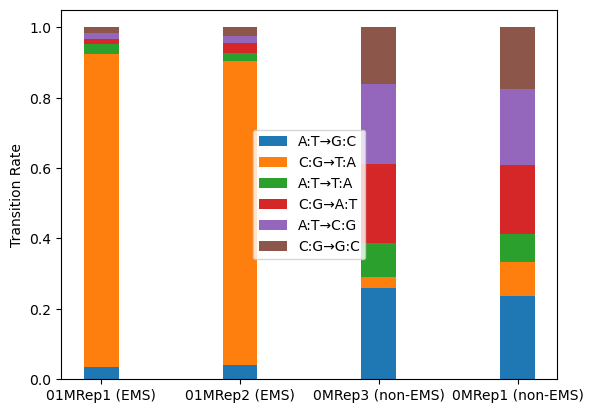

In [23]:
fig, ax = plt.subplots()

width = 0.25
bottom = np.zeros(4)

for name, probs in conversions_to_plot.items():
    ax.bar(sample_name_key.values(), probs, width, bottom=bottom, label=f'{name}')
    bottom += probs

ax.set_ylabel('Transition Rate')
ax.legend(loc='center')

plt.show()

This is quite cool -- EMS is [known to induce mainly C:G→T:A mutations](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2022.1052569/full), and we see an enormous rate increase of that kind of mutation in the EMS sample vs. the one that was allowed to evolve on its own.

Another thing we want to know is what proportion of the reads in the population have each variant. *Nanno* is haploid, but we sequenced a population; so the proportion of reads containing a given variant represents the proportion of the population containing that mutation. Strelka's docs provide a [procedure for calculating alternate allele frequency](https://github.com/Illumina/strelka/blob/v2.9.x/docs/userGuide/README.md#somatic) from the `vcf` file, which we'll implement here:

```
refCounts = Value of FORMAT column $REF + “U” (e.g. if REF="A" then use the value in FOMRAT/AU)
altCounts = Value of FORMAT column $ALT + “U” (e.g. if ALT="T" then use the value in FOMRAT/TU)
tier1RefCounts = First comma-delimited value from $refCounts
tier1AltCounts = First comma-delimited value from $altCounts
Somatic allele freqeuncy is $tier1AltCounts / ($tier1AltCounts + $tier1RefCounts)
```

Note that this is a formula, not a code snippet, so our implementation below will look different. I can't figure out a straightforward way to get the values from the custom columns of the `vcf` with `pysam`, so I'll just read it in as a dataframe, skipping the rows beginning with `#`.

In [24]:
def loadVCF(vcf):
    """
    Use pandas to load a vcf as a dataframe.
    """
    # Detect true header row
    with gzip.open(vcf, 'rb') as f:
        for i, l in enumerate(f.readlines()):
            if l.decode()[0] != '#':
                header_row = i - 1 # Want the last row starting with #
                break

    # Load vcf
    df = pd.read_csv(vcf, sep='\t', header=header_row)

    return df
    

def calculateAlleleFreqs(vcf, indels=False):
    """
    Calculate minor allele frequencies for every variant in a vcf.

    parameters:
        vcf, str: path to a vcf file
        indels, bool: whether or not the file contains indels or SNVs
        
    returns:
        alt_freq_dict, dict: keys are variants (as <chrom>_<pos>_<ref>_<alt>),
            values are a dict of allele frequencies between 0 and 1 for each base
    """
    # Headers are:
    #CHROM	POS	ID	REF	ALT	QUAL FILTER	INFO FORMAT	NORMAL TUMOR
    variant_df = loadVCF(vcf)

    # Could do this with apply, but I don't think that's actually any
    # faster than iterating directly, and this is simpler to read
    alt_freq_dict = {}
    for i, variant in tqdm(variant_df.iterrows()):

        # Get the count values -- need to coprresond the position in the FORMAT
        # string with the value in the TUMOR string

        ref_indexer = 'TAR' if indels else f'{variant.REF}U'
        ref_count_idx = variant.FORMAT.split(':').index(ref_indexer)
        ref_count = int(variant.TUMOR.split(':')[ref_count_idx].split(',')[0])
        # print(f"Tier1 count: {int(variant.TUMOR.split(':')[ref_count_idx].split(',')[0])}, tier2 count: {int(variant.TUMOR.split(':')[ref_count_idx].split(',')[1])}")

        alt_indexer = 'TIR' if indels else f'{variant.ALT}U'
        alt_count_idx = variant.FORMAT.split(':').index(alt_indexer)
        alt_count = int(variant.TUMOR.split(':')[alt_count_idx].split(',')[0])


        # Calculate frequency
        alt_freq = alt_count / (alt_count + ref_count)

        # Add to dict
        alt_freq_dict['_'.join([variant['#CHROM'], str(variant.POS), variant.REF, variant.ALT])] = alt_freq

    return alt_freq_dict

In [29]:
all_alt_freqs = {}
for sample, snv_path in filtered_snv_paths.items():
    all_alt_freqs[sample] = calculateAlleleFreqs(snv_path)

549it [00:00, 11416.72it/s]
556it [00:00, 11444.66it/s]
31it [00:00, 10764.42it/s]
51it [00:00, 11302.41it/s]


Now let's make a violin plot of the frequencies:

In [31]:
for_violin = [(sample_name_key[k], freq) for k, v in all_alt_freqs.items() for freq in v.values()]


for_violin_df = pd.DataFrame.from_records(for_violin, columns=['sample', 'alt_frequency'])
for_violin_df.head()

,sample,alt_frequency
0,01MRep1 (EMS),0.217082
1,01MRep1 (EMS),0.053156
2,01MRep1 (EMS),0.022472
3,01MRep1 (EMS),0.030986
4,01MRep1 (EMS),0.162534


<Axes: xlabel='sample', ylabel='alt_frequency'>

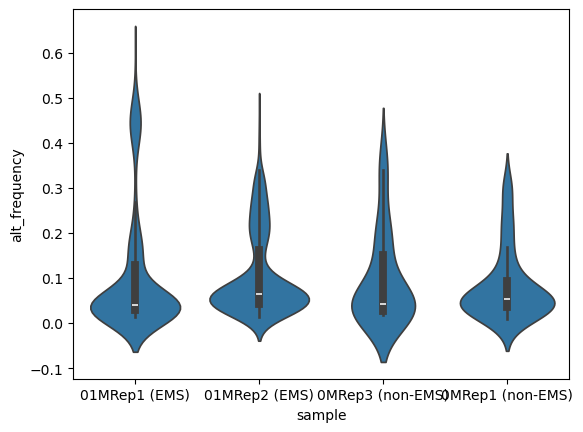

In [32]:
sns.violinplot(for_violin_df, x='sample', y='alt_frequency')

The violin plot indicates that no more than 50% of the population has any given variant. What are the mins and maxes, and which variants do they correspond to?

In [37]:
for sample, freqs in all_alt_freqs.items():
    print(f'Maximum frequency is for variant {max(freqs, key=freqs.get)}, with a frequency of {max(freqs.values()):.3f}')

Maximum frequency is for variant scf_28_29835_G_A, with a frequency of 0.584
Maximum frequency is for variant scf_10_283569_G_A, with a frequency of 0.459
Maximum frequency is for variant scf_21_197250_A_C, with a frequency of 0.375
Maximum frequency is for variant scf_21_197250_A_C, with a frequency of 0.306


How many of the variants are in common across the two reps for each sample?

In [83]:
var_shared_non_EMS = set(all_alt_freqs['0MRep1_vs_537controlRep2'].keys()).intersection(set(all_alt_freqs['0MRep3_vs_537controlRep2'].keys()))
print(f'There are {len(var_shared_non_EMS)} variants in common for the non-EMS replicates (of {len(set(all_alt_freqs["0MRep1_vs_537controlRep2"].keys()))} and {len(set(all_alt_freqs["0MRep3_vs_537controlRep2"].keys()))}).')

There are 11 variants in common for the non-EMS replicates (of 51 and 31).


In [89]:
var_shared_EMS = set(all_alt_freqs['01MRep1_vs_537controlRep2'].keys()).intersection(set(all_alt_freqs['01MRep2_vs_537controlRep2'].keys()))
print(f'There are {len(var_shared_EMS)} variants in common for the EMS replicates (of {len(set(all_alt_freqs["01MRep1_vs_537controlRep2"].keys()))} and {len(set(all_alt_freqs["01MRep2_vs_537controlRep2"].keys()))}).')

There are 405 variants in common for the EMS replicates (of 549 and 556).


## Indels
Thus far we've only looked at the SNVs in our data; what about the indels?

In [38]:
for sample, filepath in indel_filepaths.items():
    vcf = VariantFile(filepath)
    variants = vcf.fetch()
    print(f'Indel variants for sample {sample}:')
    print('-------------------------------------------')
    passed = []
    total = 0
    for variant in variants:
        if variant.filter.keys()[0] == 'PASS':
            print(variant.chrom, variant.pos, variant.ref, ">", variant.alts[0], variant.qual, variant.filter.values()[0].name)
            passed.append(variant)
        total += 1
    print(f'\nFor sample {sample}, {len(passed)} of {total} variants passed, which is {(len(passed)/total)*100:.2f}%.\n')

Indel variants for sample 01MRep1_vs_537controlRep2:
-------------------------------------------
scf_2 120586 T > TTCCC None PASS
scf_2 185855 AGAG > A None PASS
scf_6 712028 GCGC > G None PASS
scf_6 1025167 TTCC > T None PASS
scf_14 627792 C > CCCCTCTCT None PASS
scf_14 675746 T > TC None PASS
scf_16 605303 T > TTA None PASS
scf_19 215751 GAA > G None PASS
scf_24 1002851 TCTGGAA > T None PASS
scf_29 214010 CT > C None PASS
scf_29 289508 GGGA > G None PASS
scf_35 333030 TCTC > T None PASS

For sample 01MRep1_vs_537controlRep2, 12 of 899 variants passed, which is 1.33%.

Indel variants for sample 01MRep2_vs_537controlRep2:
-------------------------------------------
scf_6 712028 GCGC > G None PASS
scf_14 627792 C > CCCCTCTCT None PASS
scf_16 149718 A > AAT None PASS
scf_19 707589 T > TC None PASS
scf_20 158358 A > AG None PASS
scf_24 819444 TG > T None PASS
scf_24 1002851 TCTGGAA > T None PASS
scf_29 211683 CAT > C None PASS
scf_32 550041 C > CG None PASS

For sample 01MRep2_vs_537contr

There are way fewer indel mutants than point mutations, and a similar number between the normal and EMS mutants, which makes sense, as EMS induces point mutations. Write them out:

In [39]:
# Adapted from the Gemini suggested answer
filtered_indel_paths = {}
for sample in indel_filepaths.keys():
    indel_path = f'{var_top_path}/{sample}/{sample}.strelka.somatic_indels.vcf.gz'
    filtered_path = f'{var_top_path}/{sample}/{sample}.strelka.somatic_indels_FILTERED.vcf.gz'
    filtered_indel_paths[sample] = filtered_path

    with VariantFile(indel_path) as vcf_in, \
         VariantFile(filtered_path, 'w', header=vcf_in.header) as vcf_out:
    
        for record in vcf_in:
            if 'PASS' in record.filter.keys():
                vcf_out.write(record)

Calculate the alternate allele frequencies of the indels, following the procedure provided by strelka (modified the previous function to have an indels option):

```
tier1RefCounts = First comma-delimited value from FORMAT/TAR
tier1AltCounts = First comma-delimited value from FORMAT/TIR
Somatic allele freqeuncy is $tier1AltCounts / ($tier1AltCounts + $tier1RefCounts)
```

In [41]:
all_alt_freqs_indels = {}
for sample, indel_path in filtered_indel_paths.items():
    all_alt_freqs_indels[sample] = calculateAlleleFreqs(indel_path, indels=True)

12it [00:00, 10151.60it/s]
9it [00:00, 5581.66it/s]
14it [00:00, 10292.77it/s]
14it [00:00, 10892.28it/s]


In [46]:
indel_for_violin = [(sample_name_key[k], freq) for k, v in all_alt_freqs_indels.items() for freq in v.values()]


indel_for_violin_df = pd.DataFrame.from_records(indel_for_violin, columns=['sample', 'alt_frequency'])
indel_for_violin_df.head()

,sample,alt_frequency
0,01MRep1 (EMS),0.941176
1,01MRep1 (EMS),0.142857
2,01MRep1 (EMS),0.142857
3,01MRep1 (EMS),0.142857
4,01MRep1 (EMS),0.427027


<Axes: xlabel='sample', ylabel='alt_frequency'>

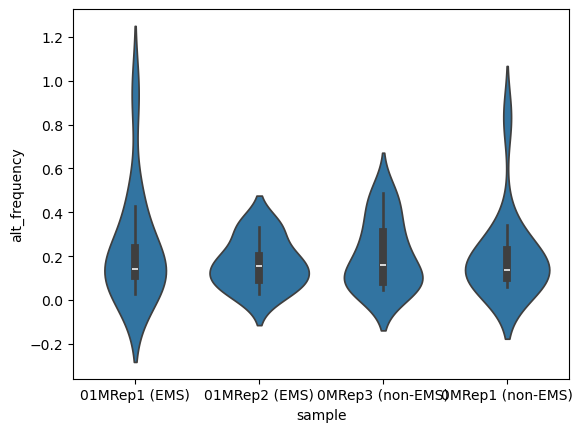

In [47]:
sns.violinplot(indel_for_violin_df, x='sample', y='alt_frequency')

This is much different than the SNVs! In the non-EMS sample, there's at least one mutation with a high frequency; what's the maximum value, and what's the indel?

In [48]:
for sample, freqs in all_alt_freqs_indels.items():
    print(f'Maximum frequency is for variant {max(freqs, key=freqs.get)}, with a frequency of {max(freqs.values()):.3f}')

Maximum frequency is for variant scf_2_120586_T_TTCCC, with a frequency of 0.941
Maximum frequency is for variant scf_14_627792_C_CCCCTCTCT, with a frequency of 0.333
Maximum frequency is for variant scf_17_66764_C_CCCTT, with a frequency of 0.490
Maximum frequency is for variant scf_19_572560_CT_C, with a frequency of 0.833


Those are high frequencies! We'll come back around to this in further investigation later on.

In [86]:
indel_shared_non_EMS = set(all_alt_freqs_indels['0MRep1_vs_537controlRep2'].keys()).intersection(set(all_alt_freqs_indels['0MRep3_vs_537controlRep2'].keys()))
print(f'There are {len(indel_shared_non_EMS)} indels in common for the non-EMS replicates (of {len(set(all_alt_freqs_indels["0MRep1_vs_537controlRep2"].keys()))} and {len(set(all_alt_freqs_indels["0MRep3_vs_537controlRep2"].keys()))}).')

There are 8 indels in common for the non-EMS replicates (of 14 and 14).


In [88]:
indel_shared_EMS = set(all_alt_freqs_indels['01MRep1_vs_537controlRep2'].keys()).intersection(set(all_alt_freqs_indels['01MRep2_vs_537controlRep2'].keys()))
print(f'There are {len(indel_shared_EMS)} variants in common for the EMS replicates (of {len(set(all_alt_freqs_indels["01MRep1_vs_537controlRep2"].keys()))} and {len(set(all_alt_freqs_indels["01MRep2_vs_537controlRep2"].keys()))}).')

There are 3 variants in common for the EMS replicates (of 12 and 9).


## Investigating mutations
We now want to narrow in on what genes these mutations may be impacting. Ideally, we want to see what genes are affected by the SNPs and indels. A useful tool for this is the [BEDtools](https://bedtools.readthedocs.io/en/latest/) module; specifically, we can [get the intersection of a SNP file with a genome annotation](https://www.biostars.org/p/379113/#379121). The bulk of this work will take place on the command line.

First, we need to convert the `gff3` annotation file to a `gtf` file with `gffread`. From within the `data/genome` directory:

```
gffread n_salina.working_models.gff3 -T -o n_salina.working_models.gtf
```
(Note: I provided the full path to where I'd cloned `gffread` rather than adding to `PATH`)

### SNVs
Next, use BEDtools to get the intersections. We'll use the built-in access to the subprocess module to do that here in the notebook:

In [63]:
# Copy these into the bash command below
print(snv_filepaths.keys())

dict_keys(['01MRep1_vs_537controlRep2', '01MRep2_vs_537controlRep2', '0MRep3_vs_537controlRep2', '0MRep1_vs_537controlRep2'])


In [62]:
%%bash
module load BEDTools/2.31.0-GCC-12.3.0
strings=(
    "01MRep1_vs_537controlRep2"
    "01MRep2_vs_537controlRep2"
    "0MRep3_vs_537controlRep2"
    "0MRep1_vs_537controlRep2"
)
for string in "${strings[@]}"; do
    echo $string
    bedtools intersect \
        -wa -wb \
        -a "/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka/${string}/${string}.strelka.somatic_snvs_FILTERED.vcf.gz" -b /mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/genome/n_salina.working_models.gtf > "/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka/${string}/${string}_FILTERED_SNVs_overlap_with_annotations.txt"
done

01MRep1_vs_537controlRep2
01MRep2_vs_537controlRep2
0MRep3_vs_537controlRep2
0MRep1_vs_537controlRep2


Now read in the files we generated:

In [65]:
snv_intersects = {}
for sample in snv_filepaths.keys():
    df = pd.read_csv(f'/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka/{sample}/{sample}_FILTERED_SNVs_overlap_with_annotations.txt', sep='\t', header=None)
    snv_intersects[sample] = df

In [67]:
snv_intersects['01MRep1_vs_537controlRep2'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,scf_1,324385,.,C,T,.,PASS,SOMATIC;QSS=80;TQSS=2;NT=ref;QSS_NT=80;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:2:0:0:0,0:143,149:0,0:0,0","271:4:0:0:0,0:261,268:0,0:6,6",scf_1,MSU_v1,transcript,320494,324789,.,-,.,"transcript_id ""N_sal.S001040.1""; gene_id ""N_sa..."
1,scf_1,324385,.,C,T,.,PASS,SOMATIC;QSS=80;TQSS=2;NT=ref;QSS_NT=80;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:2:0:0:0,0:143,149:0,0:0,0","271:4:0:0:0,0:261,268:0,0:6,6",scf_1,MSU_v1,exon,321745,324789,.,-,.,"transcript_id ""N_sal.S001040.1""; gene_id ""N_sa..."
2,scf_1,324385,.,C,T,.,PASS,SOMATIC;QSS=80;TQSS=2;NT=ref;QSS_NT=80;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"145:2:0:0:0,0:143,149:0,0:0,0","271:4:0:0:0,0:261,268:0,0:6,6",scf_1,MSU_v1,CDS,321745,324789,.,-,0,"transcript_id ""N_sal.S001040.1""; gene_id ""N_sa..."
3,scf_1,346370,.,C,T,.,PASS,SOMATIC;QSS=97;TQSS=1;NT=ref;QSS_NT=97;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"198:1:0:0:0,0:197,199:0,0:0,0","364:9:0:0:0,0:344,350:0,0:11,15",scf_1,MSU_v1,transcript,343441,348037,.,+,.,"transcript_id ""N_sal.S001130.1""; gene_id ""N_sa..."
4,scf_1,346370,.,C,T,.,PASS,SOMATIC;QSS=97;TQSS=1;NT=ref;QSS_NT=97;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"198:1:0:0:0,0:197,199:0,0:0,0","364:9:0:0:0,0:344,350:0,0:11,15",scf_1,MSU_v1,exon,343441,347049,.,+,.,"transcript_id ""N_sal.S001130.1""; gene_id ""N_sa..."


Columns 0-10 are the SNVs data, while 11-19 are from the genome annotation. What we really want is the gene name from the last column for each SNV:

In [68]:
for sample, df in snv_intersects.items():
    df['gene_name'] = df[19].str.split('"').str[1]

For now, we'll only keep the CDS objects:

In [70]:
for sample, df in snv_intersects.items():
    snv_intersects[sample] = df[df[13] == 'CDS'].reset_index(drop=True)

How many SNV-affected genes do we have in each mutant?

In [72]:
for sample, df in snv_intersects.items():
    print(f"There are {df.groupby(by='gene_name').count().shape[0]} SNV-affected genes in sample {sample}")

There are 341 SNV-affected genes in sample 01MRep1_vs_537controlRep2
There are 345 SNV-affected genes in sample 01MRep2_vs_537controlRep2
There are 25 SNV-affected genes in sample 0MRep3_vs_537controlRep2
There are 40 SNV-affected genes in sample 0MRep1_vs_537controlRep2


How many of these genes overlap in the replicates for a given treatment condition?

In [79]:
in_common_non_EMS = set(snv_intersects['0MRep1_vs_537controlRep2']['gene_name'].tolist()).intersection(set(snv_intersects['0MRep3_vs_537controlRep2']['gene_name'].tolist()))
print(f"For the non-EMS samples, there are {len(in_common_non_EMS)} SNV-affected genes in common.")

For the non-EMS samples, there are 8 SNV-affected genes in common.


In [80]:
in_common_EMS = set(snv_intersects['01MRep1_vs_537controlRep2']['gene_name'].tolist()).intersection(set(snv_intersects['01MRep2_vs_537controlRep2']['gene_name'].tolist()))
print(f"For the EMS samples, there are {len(in_common_EMS)} SNV-affected genes in common.")

For the EMS samples, there are 257 SNV-affected genes in common.


It makes sense to me that the non-EMS mutants might not have much in common -- because these are biological replicates that grew separately, so there's no environmental factor like EMS to drive a similar kind of mutations. I'm going to leave all the SNVs in the following analyses, but then check them back against these lists of in-common affected genes.

Now let's check if there are any genes in either condition with more than one SNV:

In [91]:
genes_more_than_one_SNV = {}
for sample, df in snv_intersects.items():
    counted = df.groupby(by='gene_name').count()
    num_greater = len(counted[counted[0] > 1])
    genes_more_than_one_SNV[sample] = counted[counted[0] > 1]
    print(f'For sample {sample}, there are {num_greater} genes containing more than one SNV.')

For sample 01MRep1_vs_537controlRep2, there are 10 genes containing more than one SNV.
For sample 01MRep2_vs_537controlRep2, there are 11 genes containing more than one SNV.
For sample 0MRep3_vs_537controlRep2, there are 0 genes containing more than one SNV.
For sample 0MRep1_vs_537controlRep2, there are 0 genes containing more than one SNV.


How many of the genes with more than one SNV overlap between the two reps?

In [94]:
in_common_multiple_SNVs = set(genes_more_than_one_SNV['01MRep1_vs_537controlRep2'].index.tolist()).intersection(genes_more_than_one_SNV['01MRep2_vs_537controlRep2'].index.tolist())
print(f'There are {len(in_common_multiple_SNVs)} genes with multiple SNVs in common between the two conditions')

There are 6 genes with multiple SNVs in common between the two conditions


What are those 6?

In [95]:
in_common_multiple_SNVs

{'N_sal.S003590.1',
 'N_sal.S003590.2',
 'N_sal.S014430.1',
 'N_sal.S020450.1',
 'N_sal.S022810.1',
 'N_sal.S050120.1'}

Later on, we'll also check for genes that additionally contain indels.

Check how many genes overlap between the two conditions with any number of SNVs:

In [111]:
cross_condition = in_common_EMS.intersection(in_common_non_EMS)
cross_condition

{'N_sal.S084590.1'}

Only 1 gene overlap between the two conditions in all reps!

### Indels
Now let's look at which indels appear in coding regions:

In [96]:
%%bash
module load BEDTools/2.31.0-GCC-12.3.0
strings=(
    "01MRep1_vs_537controlRep2"
    "01MRep2_vs_537controlRep2"
    "0MRep3_vs_537controlRep2"
    "0MRep1_vs_537controlRep2"
)
for string in "${strings[@]}"; do
    echo $string
    bedtools intersect \
        -wa -wb \
        -a "/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka/${string}/${string}.strelka.somatic_indels_FILTERED.vcf.gz" -b /mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/genome/n_salina.working_models.gtf > "/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka/${string}/${string}_FILTERED_indels_overlap_with_annotations.txt"
done

01MRep1_vs_537controlRep2
01MRep2_vs_537controlRep2
0MRep3_vs_537controlRep2
0MRep1_vs_537controlRep2


In [97]:
indel_intersects = {}
for sample in indel_filepaths.keys():
    df = pd.read_csv(f'/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/separate_samplesheets_strelka/variant_calling/strelka/{sample}/{sample}_FILTERED_indels_overlap_with_annotations.txt', sep='\t', header=None)
    indel_intersects[sample] = df

In [98]:
for sample, df in indel_intersects.items():
    df['gene_name'] = df[19].str.split('"').str[1]
    indel_intersects[sample] = df[df[13] == 'CDS'].reset_index(drop=True)

In [100]:
for sample, df in indel_intersects.items():
    print(f"There are {df.groupby(by='gene_name').count().shape[0]} indel-affected genes in sample {sample}")

There are 2 indel-affected genes in sample 01MRep1_vs_537controlRep2
There are 1 indel-affected genes in sample 01MRep2_vs_537controlRep2
There are 4 indel-affected genes in sample 0MRep3_vs_537controlRep2
There are 2 indel-affected genes in sample 0MRep1_vs_537controlRep2


Only  a few indels overlap coding regions -- do any of them overlap between the reps?

In [101]:
indels_in_common_non_EMS = set(indel_intersects['0MRep1_vs_537controlRep2']['gene_name'].tolist()).intersection(set(indel_intersects['0MRep3_vs_537controlRep2']['gene_name'].tolist()))
print(f"For the non-EMS samples, there are {len(indels_in_common_non_EMS)} indel-affected genes in common between reps.")

For the non-EMS samples, there are 2 indel-affected genes in common between reps.


In [103]:
indel_in_common_EMS = set(indel_intersects['01MRep1_vs_537controlRep2']['gene_name'].tolist()).intersection(set(indel_intersects['01MRep2_vs_537controlRep2']['gene_name'].tolist()))
print(f"For the EMS samples, there are {len(indel_in_common_EMS)} indel-affected genes in common.")

For the EMS samples, there are 0 indel-affected genes in common.


What are the in-common ones for the non_EMS samples?

In [104]:
indels_in_common_non_EMS

{'N_sal.S061470.1', 'N_sal.S084590.1'}

### Combining indels and SNVs
A very compelling candidate gene might be affected by both SNVs and indels; do we have any of those?

In [105]:
indels_in_common_non_EMS.intersection(in_common_non_EMS)

{'N_sal.S084590.1'}

In [107]:
indel_in_common_EMS.intersection(in_common_EMS)

set()

We also want to crosscheck these for overlapping genes; a similar phenotype could be caused by one sample having a SNP in the gene while the other has an indel.

In [108]:
indels_in_common_non_EMS.intersection(in_common_EMS)

{'N_sal.S084590.1'}

In [109]:
indel_in_common_EMS.intersection(in_common_non_EMS)

set()

This is the same gene as before; because both samples have SNPs in it, in addition to the non-EMS sample having an indel there.

Lastly, let's start building a dataframe of potential genes of interest.

In [120]:
len(list(in_common_multiple_SNVs)), len([g for glist in genes_more_than_one_SNV.values() for g in glist.index.tolist()]), len(list(indels_in_common_non_EMS)), len(list(in_common_EMS)), len(list(in_common_non_EMS))

(6, 21, 2, 257, 8)

In [122]:
candidate_gene_list = list(set(list(in_common_multiple_SNVs) + [g for glist in genes_more_than_one_SNV.values() for g in glist.index.tolist()] + list(indels_in_common_non_EMS) + list(cross_condition)))
candidate_gene_list

['N_sal.S014430.1',
 'N_sal.S061080.1',
 'N_sal.S055080.2',
 'N_sal.S028860.1',
 'N_sal.S037470.1',
 'N_sal.S022810.1',
 'N_sal.S084590.1',
 'N_sal.S055080.1',
 'N_sal.S003590.1',
 'N_sal.S003590.2',
 'N_sal.S055080.3',
 'N_sal.S072340.1',
 'N_sal.S014930.1',
 'N_sal.S020450.1',
 'N_sal.S050120.1',
 'N_sal.S047240.1',
 'N_sal.S061470.1']

In [195]:
## TODO generalize this for new candidate genes
# Add EMS SNV counts
candidate_gene_df = counted_ems[[0]].rename(columns={0:'num_genic_snvs_0_1M_R2'}).merge(pd.DataFrame(candidate_gene_list, columns=['gene_id']), left_index=True, right_on='gene_id')
# Add non-EMS SNV counts
candidate_gene_df = candidate_gene_df.merge(counted_normal[[0]].rename(columns={0:'num_genic_snvs_0M_R1'}), left_on='gene_id', right_index=True, how='left').fillna(0).reset_index(drop=True)
# Add EMS indel counts
candidate_gene_df = indel_intersects_0_1M_R2.groupby(by='gene_name').count()[[0]].rename(columns={0:'num_genic_indels_0_1M_R2'}).merge(candidate_gene_df, left_index=True, right_on='gene_id', how='outer').fillna(0).reset_index(drop=True)
# Add regular indel counts
candidate_gene_df = indel_intersects_0M_R1.groupby(by='gene_name').count()[[0]].rename(columns={0:'num_genic_indels_0M_R1'}).merge(candidate_gene_df, left_index=True, right_on='gene_id', how='outer').fillna(0).reset_index(drop=True)

In [197]:
candidate_gene_df.to_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/candidate_genes/genic_variants_30Jul2025.csv', index=False)

## Combining allele frequencies and gene annotations
We've separately seen that no allele has an alternate frequency of more than 0.5, and we've matched SNVs to genes. But do our high-frequency alleles correspond with genic regions, or do they account for some of the non-coding sequence mutations that we filtered out in the previous step?

First, make a map between gene names and the notation we've been using to identify individual SNVs:

In [88]:
gene_intersects_0M_R1['snv_id'] = gene_intersects_0M_R1[0] + '_' + gene_intersects_0M_R1[1].astype('str') + '_' + gene_intersects_0M_R1[3] + '_' + gene_intersects_0M_R1[4]
snv2gene_0M_R1 = gene_intersects_0M_R1[['snv_id', 'gene_name']].set_index('snv_id').to_dict()['gene_name']

In [89]:
gene_intersects_0_1M_R2['snv_id'] = gene_intersects_0_1M_R2[0] + '_' + gene_intersects_0_1M_R2[1].astype('str') + '_' + gene_intersects_0_1M_R2[3] + '_' + gene_intersects_0_1M_R2[4]
snv2gene_0_1M_R2 = gene_intersects_0_1M_R2[['snv_id', 'gene_name']].set_index('snv_id').to_dict()['gene_name']

Now, let's make a swarmplot of the allele frequencies, coloring those in genic regions a different color:

In [156]:
all_gene_intersects = pd.concat([gene_intersects_0M_R1, gene_intersects_0_1M_R2])
def catch_non_genic(df, snv_id):
    """
    Ignores isoforms.
    """
    try:
        return df.loc[df['snv_id'] == snv_id, 'gene_name'].values[0]
    except IndexError:
        return np.nan
# The amount of work I just did to make this list comprehension work instead of making a regular loop is comical lol
for_swarm = [(k, snv_id, freq, True if snv_id in gene_intersects_0M_R1['snv_id'].tolist() + gene_intersects_0_1M_R2['snv_id'].tolist() else False, catch_non_genic(all_gene_intersects, snv_id))
             for k, v in
             {'0M_R1': alt_freqs_0M_R1,
                 '0_1M_R2': alt_freqs_0_1M_R2}.items()
             for snv_id, freq in v.items()]


for_swarm_df = pd.DataFrame.from_records(for_swarm, columns=['sample', 'snv_id', 'alt_frequency', 'is_genic', 'snv_gene'])
for_swarm_df.head()

,sample,snv_id,alt_frequency,is_genic,snv_gene
0,0M_R1,scf_1_167764_T_G,0.048387,True,N_sal.S000450.1
1,0M_R1,scf_1_860759_C_A,0.226087,False,NaN
2,0M_R1,scf_1_947966_G_C,0.093960,True,N_sal.S003280.1
3,0M_R1,scf_2_295083_A_C,0.111111,True,N_sal.S015940.1
4,0M_R1,scf_2_371413_C_G,0.039801,True,N_sal.S016180.1


<Axes: xlabel='sample', ylabel='alt_frequency'>

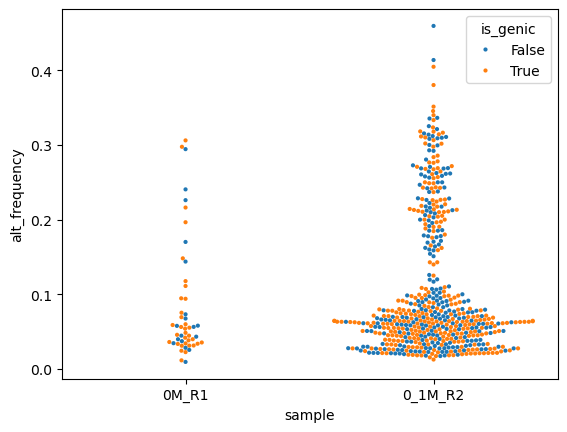

In [91]:
sns.swarmplot(data=for_swarm_df, x='sample', y='alt_frequency', hue='is_genic', size=3)

There appears to be no relationship between whether or not the SNV is genic and whether or not it has a high frequency in the population. Where do the genes of interest we've identified (those overlapping in both samples) fall here?

In [92]:
overlapping_snps

{'N_sal.S003280.1', 'N_sal.S084590.1', 'N_sal.S088740.1'}

In [93]:
gene2snv_0M_R1 = {v: k for k, v in snv2gene_0M_R1.items()}
gene2snv_0_1M_R2 = {v: k for k, v in snv2gene_0_1M_R2.items()}

In [94]:
for g in overlapping_snps:
    freq_0M_R1 = alt_freqs_0M_R1[gene2snv_0M_R1[g]]
    freq_0_1M_R2 = alt_freqs_0_1M_R2[gene2snv_0_1M_R2[g]]
    print(f'The allele frequency of gene {g} in the non-EMS sample is {freq_0M_R1:.2f}, while in the EMS sample its frequency is {freq_0_1M_R2:.2f}')

The allele frequency of gene N_sal.S088740.1 in the non-EMS sample is 0.07, while in the EMS sample its frequency is 0.06
The allele frequency of gene N_sal.S003280.1 in the non-EMS sample is 0.09, while in the EMS sample its frequency is 0.08
The allele frequency of gene N_sal.S084590.1 in the non-EMS sample is 0.31, while in the EMS sample its frequency is 0.22


Only one of the three genes has a high alternate allele frequency in either population.

What about the indels?

In [95]:
indel_intersects_0M_R1['indel_id'] = indel_intersects_0M_R1[0] + '_' + indel_intersects_0M_R1[1].astype('str') + '_' + indel_intersects_0M_R1[3] + '_' + indel_intersects_0M_R1[4]
indel2gene_0M_R1 = indel_intersects_0M_R1[['indel_id', 'gene_name']].set_index('indel_id').to_dict()['gene_name']

In [96]:
indel_intersects_0_1M_R2['indel_id'] = indel_intersects_0_1M_R2[0] + '_' + indel_intersects_0_1M_R2[1].astype('str') + '_' + indel_intersects_0_1M_R2[3] + '_' + indel_intersects_0_1M_R2[4]
indel2gene_0_1M_R2 = indel_intersects_0_1M_R2[['indel_id', 'gene_name']].set_index('indel_id').to_dict()['gene_name']

In [97]:
indel_for_swarm = [(k, indel_id, freq, True if indel_id in indel_intersects_0M_R1['indel_id'].tolist() + indel_intersects_0_1M_R2['indel_id'].tolist() else False)
             for k, v in
             {'0M_R1': indel_freqs_0M_R1,
                 '0_1M_R2': indel_freqs_0_1M_R2}.items()
             for indel_id, freq in v.items()]


indel_for_swarm_df = pd.DataFrame.from_records(indel_for_swarm, columns=['sample', 'indel_id', 'alt_frequency', 'is_genic'])
indel_for_swarm_df.head()

,sample,indel_id,alt_frequency,is_genic
0,0M_R1,scf_2_453749_AC_A,0.242105,False
1,0M_R1,scf_9_1044578_C_CAATA,0.077778,False
2,0M_R1,scf_11_803969_T_TCGACGG,0.174419,True
3,0M_R1,scf_14_38344_CA_C,0.083333,False
4,0M_R1,scf_17_66764_C_CCCTT,0.342105,False


<Axes: xlabel='sample', ylabel='alt_frequency'>

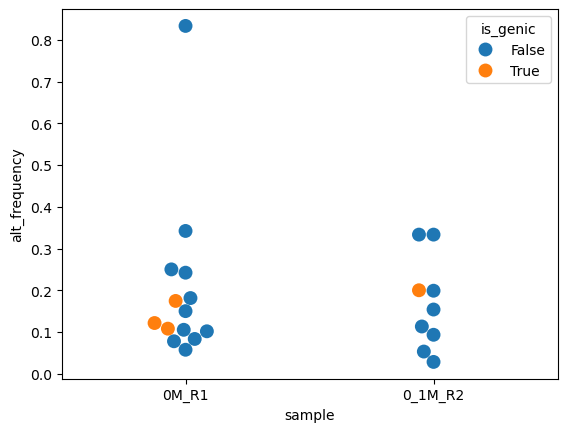

In [98]:
sns.swarmplot(data=indel_for_swarm_df, x='sample', y='alt_frequency', hue='is_genic', size=10)

There are a lot fewer indels than SNVs so it's less clear what pattern may or may not be present here in terms of the relationships bewteen the indels and genic regions. However, we can see that the high-frequency allele in the non-EMS population is not in a genic region -- maybe it impacts a motif?

## Looking for mutations within promoters
We want to know if any of the non-genic mutations are within the region 500bp upstream of the promoter, as many cit-regulatory motifs are found within that region. Conveniently, we have the start sites of all the coding sequences in our annotation `.gtf` file, we just have to read them in.

In [101]:
annotation = pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/genome/n_salina.working_models.gtf', names=[ # Taken from http://useast.ensembl.org/info/website/upload/gff.html
    'seqname',
    'source',
    'feature',
    'start',
    'end',
    'score',
    'strand',
    'frame',
    'attribute' 
],
    sep='\t')

In [102]:
annotation.head()

,seqname,source,feature,start,end,score,strand,frame,attribute
0,scf_11,MSU_v1,transcript,1931,4136,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa..."
1,scf_11,MSU_v1,exon,1931,2105,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa..."
2,scf_11,MSU_v1,exon,2204,2345,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa..."
3,scf_11,MSU_v1,exon,2569,2680,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa..."
4,scf_11,MSU_v1,exon,3270,3392,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa..."


Filter to get just the transcripts. We used CDS above, but they're broken into the same pieces as the exons, so for this anlaysis we'll take the entire transcript:

In [103]:
annotation_trans = annotation[annotation['feature']=='transcript']
annotation_trans.head()

,seqname,source,feature,start,end,score,strand,frame,attribute
0,scf_11,MSU_v1,transcript,1931,4136,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa..."
13,scf_11,MSU_v1,transcript,4320,5601,.,-,.,"transcript_id ""N_sal.S058760.1""; gene_id ""N_sa..."
24,scf_11,MSU_v1,transcript,6381,7726,.,+,.,"transcript_id ""N_sal.S058770.1""; gene_id ""N_sa..."
37,scf_11,MSU_v1,transcript,7788,8845,.,+,.,"transcript_id ""N_sal.S058780.1""; gene_id ""N_sa..."
44,scf_11,MSU_v1,transcript,9693,10266,.,-,.,"transcript_id ""N_sal.S058790.1""; gene_id ""N_sa..."


In order to get the 500bp uptream regions, we need to account for the strandedness of each feature. For genes on the negative strand, the start site is actually the end of the gene, because the start value is always smaller than the end value.

In [104]:
def getPromoterStart(row):
    if row.strand == '+':
        return row.start - 500
    elif row.strand == '-':
        return row.end + 500

def getTSS(row):
    if row.strand == '+':
        return row.start
    elif row.strand == '-':
        return row.end

annotation_trans.loc[:, 'fiveHundred_upstream'] = annotation_trans.apply(getPromoterStart, axis=1)
annotation_trans.loc[:, 'TSS'] = annotation_trans.apply(getTSS, axis=1)

/tmp/ipykernel_242924/3539138559.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_trans.loc[:, 'fiveHundred_upstream'] = annotation_trans.apply(getPromoterStart, axis=1)
/tmp/ipykernel_242924/3539138559.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_trans.loc[:, 'TSS'] = annotation_trans.apply(getTSS, axis=1)


In [105]:
annotation_trans.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,fiveHundred_upstream,TSS
0,scf_11,MSU_v1,transcript,1931,4136,.,-,.,"transcript_id ""N_sal.S058750.1""; gene_id ""N_sa...",4636,4136
13,scf_11,MSU_v1,transcript,4320,5601,.,-,.,"transcript_id ""N_sal.S058760.1""; gene_id ""N_sa...",6101,5601
24,scf_11,MSU_v1,transcript,6381,7726,.,+,.,"transcript_id ""N_sal.S058770.1""; gene_id ""N_sa...",5881,6381
37,scf_11,MSU_v1,transcript,7788,8845,.,+,.,"transcript_id ""N_sal.S058780.1""; gene_id ""N_sa...",7288,7788
44,scf_11,MSU_v1,transcript,9693,10266,.,-,.,"transcript_id ""N_sal.S058790.1""; gene_id ""N_sa...",10766,10266


Now implement the check:

In [106]:
# Make a dict to map gene names to the ordered ranges
# Need to keep track of the chromosomes too
promoter_ranges = defaultdict(dict)
for i, row in annotation_trans.iterrows():
    range_tup = (row.fiveHundred_upstream, row.TSS) if row.strand == '+' else (row.TSS, row.fiveHundred_upstream)
    promoter_ranges[row.seqname][row.attribute.split('"')[1]] = range_tup

In [111]:
# We want to do all kinds of variants for both samples
all_vcfs_filtered = {
    '0M_R1': {
        'snv': '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz',
        'indel': '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED.strelka.somatic_indels.vcf.gz'
    },
    '0_1M_R2': {
        'snv': '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz',
        'indel': '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED.strelka.somatic_indels.vcf.gz'
    }
    
}

In [112]:
# Apparently there's no way to do the core task with less than 2 nested loops (I even asked AI),
# and then because I want to go over samples and variant types, it's quadruply nested...
# I am suitably ashamed of this implementation, don't worry lol
in_promoter_for_swarm = []
for sample, files in all_vcfs_filtered.items():
    for var_type, file in files.items():
        vcf = VariantFile(file)
        for variant in tqdm(vcf.fetch()):
            variant_id = f'{variant.chrom}_{variant.pos}_{variant.ref}_{variant.alts[0]}'
            for gene, prom_rng in promoter_ranges[variant.chrom].items():
                if (prom_rng[0] <= variant.pos <= prom_rng[1]):
                    for_swarm_format = (sample, var_type, variant_id, gene, True)
                    in_promoter_for_swarm.append(for_swarm_format)

[E::idx_find_and_load] Could not retrieve index file for '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz'
51it [00:00, 12553.37it/s]
[E::idx_find_and_load] Could not retrieve index file for '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED.strelka.somatic_indels.vcf.gz'
14it [00:00, 12743.11it/s]
[E::idx_find_and_load] Could not retrieve index file for '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/nanno_sarek/strelka_output/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz'
556it [00:00, 13164.69it/s]
[E::idx_find_and_load] Could not retrieve index file for '/mnt/research/Walker_Lab_Research/S

Now combine this data with the allele frequencies so we can recreate the swarmplots with whether or not the mutations are in promoter sequences:

In [157]:
in_promoter_for_swarm_df =  pd.DataFrame(in_promoter_for_swarm, columns=['sample', 'variant_type', 'variant_id', 'promoter_gene', 'in_promoter'])
in_promoter_for_swarm_df.head()

,sample,variant_type,variant_id,promoter_gene,in_promoter
0,0M_R1,snv,scf_3_360860_A_C,N_sal.S044370.3,True
1,0M_R1,snv,scf_4_640532_G_A,N_sal.S012480.1,True
2,0M_R1,snv,scf_15_342080_A_G,N_sal.S075990.1,True
3,0M_R1,snv,scf_20_208250_T_A,N_sal.S050860.2,True
4,0M_R1,snv,scf_20_208250_T_A,N_sal.S050860.1,True


In [158]:
# Concat the snv and indel datavrames from before
for_swarm_df['variant_type'] = 'snv'
for_swarm_df = for_swarm_df.rename(columns={'snv_id': 'variant_id'})
indel_for_swarm_df['variant_type'] = 'indel'
indel_for_swarm_df = indel_for_swarm_df.rename(columns={'indel_id': 'variant_id'})
all_variants_for_swarm = pd.concat([for_swarm_df, indel_for_swarm_df])
all_variants_for_swarm.head()

,sample,variant_id,alt_frequency,is_genic,snv_gene,variant_type
0,0M_R1,scf_1_167764_T_G,0.048387,True,N_sal.S000450.1,snv
1,0M_R1,scf_1_860759_C_A,0.226087,False,NaN,snv
2,0M_R1,scf_1_947966_G_C,0.093960,True,N_sal.S003280.1,snv
3,0M_R1,scf_2_295083_A_C,0.111111,True,N_sal.S015940.1,snv
4,0M_R1,scf_2_371413_C_G,0.039801,True,N_sal.S016180.1,snv


In [159]:
# Now merge with the promoter information -- fill NaN in the in_promoter column with false
all_variants_for_swarm_in_promoter = all_variants_for_swarm.merge(in_promoter_for_swarm_df.drop_duplicates(subset=[c for c in in_promoter_for_swarm_df.columns if c not in ['snv_gene', 'promoter_gene']]), how='left', on=['sample', 'variant_id', 'variant_type'])
all_variants_for_swarm_in_promoter['in_promoter'] = all_variants_for_swarm_in_promoter['in_promoter'].fillna(False)
all_variants_for_swarm_in_promoter.head()

/tmp/ipykernel_242924/318733956.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_variants_for_swarm_in_promoter['in_promoter'] = all_variants_for_swarm_in_promoter['in_promoter'].fillna(False)


,sample,variant_id,alt_frequency,is_genic,snv_gene,variant_type,promoter_gene,in_promoter
0,0M_R1,scf_1_167764_T_G,0.048387,True,N_sal.S000450.1,snv,NaN,False
1,0M_R1,scf_1_860759_C_A,0.226087,False,NaN,snv,NaN,False
2,0M_R1,scf_1_947966_G_C,0.093960,True,N_sal.S003280.1,snv,NaN,False
3,0M_R1,scf_2_295083_A_C,0.111111,True,N_sal.S015940.1,snv,NaN,False
4,0M_R1,scf_2_371413_C_G,0.039801,True,N_sal.S016180.1,snv,NaN,False


Now make the swarmplot for SNVs:

<Axes: xlabel='sample', ylabel='alt_frequency'>

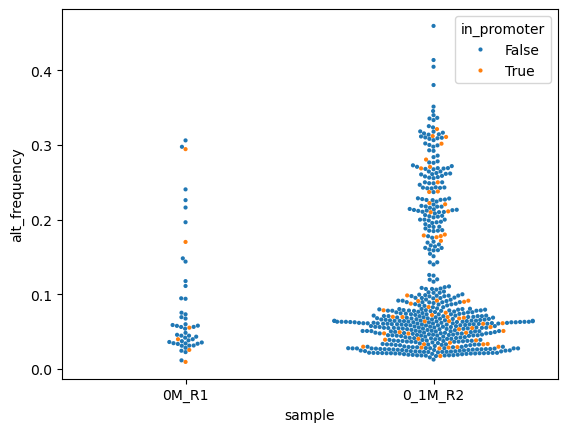

In [160]:
sns.swarmplot(data=all_variants_for_swarm_in_promoter[all_variants_for_swarm_in_promoter['variant_type']=='snv'], x='sample', y='alt_frequency', hue='in_promoter', size=3)

And the indels:

<Axes: xlabel='sample', ylabel='alt_frequency'>

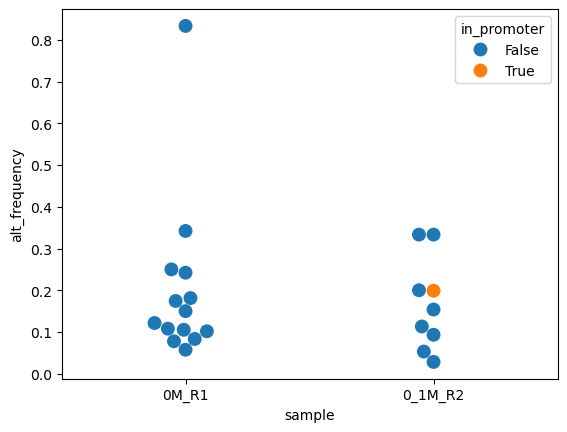

In [161]:
sns.swarmplot(data=all_variants_for_swarm_in_promoter[all_variants_for_swarm_in_promoter['variant_type']=='indel'], x='sample', y='alt_frequency', hue='in_promoter', size=10)

Like for the variants in genes, we're not seeing a relationship between alternate allele frequency and whether or not the variant is in a promoter.

Let's save out the variants that are in the promoters as a separate dataframe, as none of them overlap with the genes we've already identified.

In [190]:
promoter_to_save = in_promoter_for_swarm_df.copy()
promoter_to_save['in_promoter_0M_R1'] = promoter_to_save['sample'].map({'0M_R1': True, '0_1M_R2': False})
promoter_to_save['in_promoter_0_1M_R2'] = promoter_to_save['sample'].map({'0M_R1': False, '0_1M_R2': True})
promoter_to_save = promoter_to_save.drop(columns=['sample', 'in_promoter']).rename(columns={'promoter_gene': 'gene_id'})
promoter_to_save.head()

,variant_type,variant_id,gene_id,in_promoter_0M_R1,in_promoter_0_1M_R2
0,snv,scf_3_360860_A_C,N_sal.S044370.3,True,False
1,snv,scf_4_640532_G_A,N_sal.S012480.1,True,False
2,snv,scf_15_342080_A_G,N_sal.S075990.1,True,False
3,snv,scf_20_208250_T_A,N_sal.S050860.2,True,False
4,snv,scf_20_208250_T_A,N_sal.S050860.1,True,False


In [194]:
promoter_to_save.to_csv('../data/variants_in_promoters_30Jul2025.csv', index=False)

We also want to get the top 4 genes from each swarm, regardless of if they're found in a gene or promoter or not. We'll save this as a separate dataframe because most of them aren't related to a gene.

In [163]:
all_tops = []
for var_type in ['snv', 'indel']:
    for sample in ['0M_R1', '0_1M_R2']:
        top4 = all_variants_for_swarm_in_promoter[(all_variants_for_swarm_in_promoter['variant_type'] == var_type) & (all_variants_for_swarm_in_promoter['sample'] == sample)].nlargest(4, 'alt_frequency')
        all_tops.append(top4)
all_tops_df = pd.concat(all_tops)
all_tops_df.head()

,sample,variant_id,alt_frequency,is_genic,snv_gene,variant_type,promoter_gene,in_promoter
35,0M_R1,scf_21_197250_A_C,0.306122,True,N_sal.S084590.1,snv,NaN,False
42,0M_R1,scf_26_469894_G_C,0.297561,True,N_sal.S025870.1,snv,NaN,False
50,0M_R1,scf_36_745067_G_T,0.294416,False,NaN,snv,N_sal.S064170.1,True
44,0M_R1,scf_29_164143_A_T,0.240506,False,NaN,snv,NaN,False
268,0_1M_R2,scf_10_283569_G_A,0.459459,False,NaN,snv,NaN,False


In [192]:
all_tops_df.to_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/candidate_genes/top4_all_groups_by_frequency_30Jul2025.csv', index=False)